# Details

**For details and check the output, visit here on my github repository file:** <a href="https://github.com/HR-Fahim/CNNs-Grad-CAM-on-CIFAR-10.git">GitHub Repository</a>

# Image Preprocessing

In [1]:
# Imports

import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Select a sample image
img = train_images[0]

# Preprocess the image for VGG16
img = cv2.resize(img, (224, 224))
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

2024-06-02 20:36:17.286139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 20:36:17.286310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 20:36:17.440412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


# Load Model (VGG16)

In [2]:
# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)

# Add a logistic layer with 10 classes (for CIFAR-10)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

# This is the model we will train
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Grad-CAM

In [3]:
# Function to apply Grad-CAM
def get_grad_cam(model, img, layer_name):
    grad_model = tf.keras.models.Model(model.input, [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, np.argmax(predictions[0])]
    
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads
    
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    
    cam = np.ones(output.shape[0: 2], dtype = np.float32)
    
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    
    image = img[0, :]
    image -= image.min()
    image = np.minimum(image, 255)
    
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    
    return cam.astype('uint8')

# Output Visualization

In [4]:
# List of layers to visualize (more layers included)
layers = [
    'block1_conv1', 'block1_conv2', 
    'block2_conv1', 'block2_conv2', 
    'block3_conv1', 'block3_conv2', 'block3_conv3',
    'block4_conv1', 'block4_conv2', 'block4_conv3',
    'block5_conv1', 'block5_conv2', 'block5_conv3'
]

# Create a GIF with text
frames = []
for layer in layers:
    cam = get_grad_cam(model, img, layer)
    cam_img = Image.fromarray(cam)
    
    # Create a new image with padding at the bottom
    canvas_width = cam_img.width + 100
    canvas_height = cam_img.height + 100
    new_img = Image.new('RGB', (canvas_width, canvas_height), (0, 0, 0))
    offset = ((canvas_width - cam_img.width) // 2, 20)
    new_img.paste(cam_img, offset)
    
    # Draw text on the new image
    draw = ImageDraw.Draw(new_img)
    font = ImageFont.load_default()
    layer_details = f"Layer: {layer}, Output size: {model.get_layer(layer).output.shape[1:]}"
    text_width, text_height = draw.textsize(layer_details, font=font)
    text_position = ((canvas_width - text_width) // 2, cam_img.height + 30)
    draw.text(text_position, layer_details, font=font, fill=(255, 255, 255))
    
    frames.append(new_img)

# Create the output directory if it doesn't exist
output_dir = '/kaggle/working/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Path to save the GIF
gif_path = os.path.join(output_dir, 'grad_cam.gif')

# Save the GIF
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)

/tmp/ipykernel_18/1103624971.py:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(layer_details, font=font)
/tmp/ipykernel_18/1103624971.py:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(layer_details, font=font)
/tmp/ipykernel_18/1103624971.py:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(layer_details, font=font)
/tmp/ipykernel_18/1103624971.py:27: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(layer_details, font=font)
/tmp/ipykernel_18/1103624971.py:27: DeprecationWarning: textsize is deprecated a

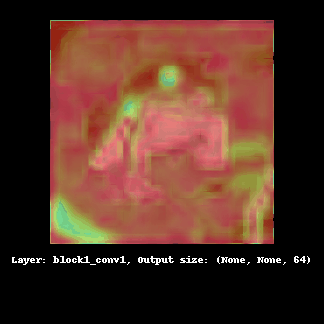

In [5]:
# Display the GIF
from IPython.display import Image as IPImage
IPImage(filename='grad_cam.gif')